# Session 6

## Classification and Localization

Localizing an object in a picture can be expressed as a regression task, to predict a bounding box around the object, a common approach is to predict the horizontal and vertical coordinates of the object’s center, as well as its height and width. This means we have 4 numbers to predict. It does not require much change to the model, we just need to add a second dense output layer with 4 units (typically on top of the global average pooling layer), and it can be trained using the MSE loss:

    base_model = keras.applications.xception.Xception(weights="imagenet",
    include_top=False)

    avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
    
    class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
    
    loc_output = keras.layers.Dense(4)(avg)
    
    model = keras.models.Model(inputs=base_model.input,
    outputs=[class_output, loc_output])
    
    model.compile(loss=["sparse_categorical_crossentropy", "mse"],
    loss_weights=[0.8, 0.2], # depends on what you care most about
    optimizer=optimizer, metrics=["accuracy"])



But now we have a problem: the flowers dataset does not have bounding boxes around the flowers. So we need to add them ourselves. This is often one of the hardest and most costly part of a Machine Learning project: getting the labels. It’s a good
idea to spend time looking for the right tools.

To annotate images with bounding boxes, you may want to use an open source image labeling tool like:
- VGG Image Annotator
- LabelImg
- OpenLabeler
- ImgLab
Or perhaps a commercial tool like:
- LabelBox
- Supervisely
You may also want to consider crowdsourcing platforms such as Amazon Mechanical Turk or CrowdFlower if you have a very large number of images to annotate. However, it is quite a lot of work to setup a crowdsourcing platform, prepare the form to be sent to the workers, to supervise them and ensure the quality of the bounding boxes they produce is good, so make sure it is worth the effort: if there are just a few thousand images to label, and you don’t plan to do this frequently, it may be preferable to do it yourself.


So let’s suppose you obtained the bounding boxes for every image in the flowers data‐set (for now we will assume there is a single bounding box per image), you then need to create a dataset whose items will be batches of preprocessed images along with
their class labels and their bounding boxes. Each item should be a tuple of the form:
(images, (class_labels, bounding_boxes)). Then you are ready to train your model!

The bounding boxes should be normalized so that the horizontal and vertical coordinates, as well as the height and width all range from 0 to 1. Also, it is common to predict the square root of the height and width rather than the height and width directly: this way, a 10 pixel error for a large bounding box will not be penalized as much as a 10 pixel error for a small bounding box.

The MSE often works fairly well as a cost function to train the model, but it is not a great metric to evaluate how well the model can predict bounding boxes. The most common metric for this is the Intersection over Union (IoU): it is the area of overlap between the predicted bounding box and the target bounding box, divided by the area of their union. 
In tf.keras, it is implemented by the `tf.keras.metrics.MeanIoU` class.

<img src="./images/Iou.png"/>

## Object Detection

The task of classifying and localizing multiple objects in an image is called object detection. Until a few years ago, a common approach was to take a CNN that was trained to classify and locate a single object, then slide it across the image, as shown.

<img src= "./images/rcnn.png"/>

In this example, the image was chopped into a 6 × 8 grid, and we show a CNN (the thick black rectangle) sliding across all 3 × 3 regions. When the CNN was looking at the top left of the image, it detected part of the left-most rose, and then it detected that same rose again when it was first shifted one step to the right. At the next step, it started detecting part of the top-most rose, and then it detected it again once it was shifted one more step to the right. You would then continue to slide the CNN through the whole image, looking at all 3 × 3 regions. Moreover, since objects can have varying sizes, you would also slide the CNN across regions of different sizes. For example, once you are done with the 3 × 3 regions, you might want to
slide the CNN across all 4 × 4 regions as well.


This technique is fairly straightforward, but as you can see it will detect the same object multiple times, at slightly different positions. Some post-processing will then be needed to get rid of all the unnecessary bounding boxes. A common approach for this is called **non-max suppression:**

• First, you need to add an extra objectness output to your CNN, to estimate the probability that a flower is indeed present in the image (alternatively, you could add a “no-flower” class, but this usually does not work as well). It must use the
sigmoid activation function and you can train it using the "binary_crossentropy" loss. Then just get rid of all the bounding boxes for which the objectness score is below some threshold: this will drop all the bounding boxes that don’t
actually contain a flower.

• Second, find the bounding box with the highest objectness score, and get rid of all the other bounding boxes that overlap a lot with it (e.g., with an IoU greater than 60%). For example, in the previous figure, the bounding box with the max object‐
ness score is the thick bounding box over the top-most rose (the objectness score is represented by the thickness of the bounding boxes). The other bounding box over that same rose overlaps a lot with the max bounding box, so we will get rid
of it.

• Third, repeat step two until there are no more bounding boxes to get rid of.


This simple approach to object detection works pretty well, but it requires running the CNN many times, so it is quite slow. Fortunately, there is a much faster way to slide a CNN across an image: using a Fully Convolutional Network.

Additionally, you can know more about the progress in this area reading about R-CNN, fast R-CNN and faster R-CNN.

## Fully Convolutional Networks (FCNs)

The idea of FCNs is about that you could replace the dense layers at the top of a CNN by convolutional layers.

To understand this, let’s look at an example: suppose a dense layer with 200 neurons sits on top of a convolutional layer that outputs 100 feature maps, each of size 7 × 7 (this is the feature map size, not the kernel size). Each neuron will compute a weighted sum of all 100 × 7 × 7 activations from the convolutional layer (plus a bias term).

Now let’s see what happens if we replace the dense layer with a convolution layer using 200 filters, each 7 × 7, and with
VALID padding. This layer will output 200 feature maps, each 1 × 1 (since the kernel is exactly the size of the input feature maps and we are using VALID padding). In other words, it will output 200 numbers, just like the dense layer did, and if you look closely at the computations performed by a convolutional layer, you will notice that these numbers will be precisely the same as the dense layer produced. The only difference is that the dense layer’s output was a tensor of shape [batch size, 200] while the convolutional layer will output a tensor of shape [batch size, 1, 1, 200].


>To convert a dense layer to a convolutional layer, the number of filters in the convolutional layer must be equal to the number of units in the dense layer, the filter size must be equal to the size of the input feature maps, and you must use VALID padding.

Why is this important? Well, while a dense layer expects a specific input size (since it has one weight per input feature), a convolutional layer will happily process images of any size24 (however, it does expect its inputs to have a specific number of channels, since each kernel contains a different set of weights for each input channel). Since an FCN contains only convolutional layers (and pooling layers, which have the same property), it can be trained and executed on images of any size!



<img src= "./images/n_in_n.png"/>


For example, suppose we already trained a CNN for flower classification and localization. It was trained on 224 × 224 images and it outputs 10 numbers: outputs 0 to 4 are sent through the softmax activation function, and this gives the class probabilities (one per class); output 5 is sent through the logistic activation function, and this gives the objectness score; outputs 6 to 9 do not use any activation function, and they represent the bounding box’s center coordinates, and its height and width. We can now convert its dense layers to convolutional layers.

In fact, we don’t even need to retrain it, we can just copy the weights from the dense layers to the convolutional layers!
Alternatively, we could have converted the CNN into an FCN before training.

Now suppose the last convolutional layer before the output layer (also called the bottleneck layer) outputs 7 × 7 feature maps when the network is fed a 224 × 224 image (see the left side of the previous figure). If we feed the FCN a 448 × 448 image (see the right side of the previous figure), the bottleneck layer will now output 14 × 14 feature maps.

Since the dense output layer was replaced by a convolutional layer using 10 filters of size 7 × 7, VALID padding and stride 1, the output will be composed of 10 features maps, each of size 8 × 8 (since 14 - 7 + 1 = 8). In other words, the FCN will process the whole image only once and it will output an 8 × 8 grid where each cell contains 10 numbers (5 class probabilities, 1 objectness score and 4 bounding box coordinates).

It’s exactly like taking the original CNN and sliding it across the image using 8 steps per row and 8 steps per column: to visualize this, imagine chopping the original image into a 14 × 14 grid, then sliding a 7 × 7 window across this grid: there will be 8 × 8 = 64 possible locations for the window, hence 8 × 8 predictions. However, the FCN approach is much more efficient, since the network only looks at the image once.
In fact, You Only Look Once (YOLO) is the name of a very popular object detection architecture!

## YOLO - Brief Overview

The “You Only Look Once,” or YOLO, family of models are a series of end-to-end deep learning models designed for fast object detection, developed by Joseph Redmon, et al. and first described in the 2015 paper titled “You Only Look Once: Unified, Real-Time Object Detection.”

The approach involves a single deep convolutional neural network (originally a version of GoogLeNet, later updated and called DarkNet based on VGG) that splits the input into a grid of cells and each cell directly predicts a bounding box and object classification. The result is a large number of candidate bounding boxes that are consolidated into a final prediction by a post-processing step.

There are multiple main variations of the approach such as YOLOv1, YOLOv2, and YOLOv3 till YOLOv7 etc. The first version proposed the general architecture, whereas the second version refined the design and made use of predefined anchor boxes to improve bounding box proposal, and version three further refined the model architecture and training process. Then, multiple modifications have been made to adapt the model to multiple input styles, augment more training data etc.

Although the accuracy of the models is close but not as good as Region-Based Convolutional Neural Networks (R-CNNs), they are popular for object detection because of their detection speed, often demonstrated in ***real-time on video or with camera feed input.***

### YOLO Demo for multiple object detection

The [official DarkNet GitHub repository](https://github.com/pjreddie/darknet) contains the source code for the YOLO versions mentioned in the papers, written in C. The repository provides a step-by-step tutorial on how to use the code for object detection.

It is a challenging model to implement from scratch, especially for beginners as it requires the development of many customized model elements for training and for prediction. For example, even using a pre-trained model directly requires sophisticated code to distill and interpret the predicted bounding boxes output by the model.

Instead of developing this code from scratch, we can use a third-party implementation. There are many third-party implementations designed for using YOLO with Keras, and none appear to be standardized and designed to be used as a library.

The "Yet Another Darknet 2 Keras" [YAD2K](https://github.com/allanzelener/YAD2K) project was a de facto standard for YOLOv2 and provided scripts to convert the pre-trained weights into Keras format, use the pre-trained model to make predictions, and provided the code required to distill interpret the predicted bounding boxes. Many other third-party developers have used this code as a starting point and updated it to support YOLOv3.

Perhaps the most widely used project for using pre-trained the YOLO models is called “[keras-yolo3](https://github.com/experiencor/keras-yolo3): Training and Detecting Objects with YOLO3” by Huynh Ngoc Anh or experiencor.

We will use experiencor’s keras-yolo3 project as the basis for performing object detection with a YOLOv3 model in this demo.

- First, we need to download the pretrained weights from [here](https://pjreddie.com/media/files/yolov3.weights).
- Next, we need to define a Keras model that has the right number and type of layers to match the downloaded model weights. The model architecture is called a “DarkNet” and was originally loosely based on the VGG-16 model.
- We will treat the code for building the model, loading the weight as a self-contained module to import, although we discussed its details during the session (you can find the record uploaded by now)
- Then, we will feed an image to the model to make an inference on, and receives its output
- The model output is relative to the training dataset images anchor boxes, carefully chosen based on an analysis of the size of objects in the MSCOCO dataset. So, we need to decode them.
- Finally, we can recieve the decoded output to visualize it on the image.

In [1]:
from yolo_model import *

In [2]:
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [3]:
# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = './images/zebra.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


zebra 99.81138110160828
zebra 93.01466345787048
zebra 97.17503190040588


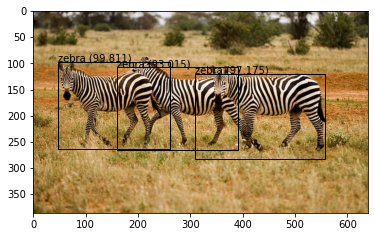

In [4]:
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

## Sources

- Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow by Aurélien Géron (O’Reilly). Copyright 2019 Aurélien Géron, 978-1-492-03264-9
- https://github.com/experiencor/keras-yolo3
- https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
- https://machinelearningmastery.com/object-recognition-with-deep-learning/
- https://learnopencv.com/cnn-fully-convolutional-image-classification-with-tensorflow/
- https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
- https://prateekvjoshi.com/2016/04/05/what-is-local-response-normalization-in-convolutional-neural-networks/
- https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
- http://introtodeeplearning.com/
- https://course.fast.ai/
- https://pyimagesearch.com/
- https://sisu.ut.ee/imageprocessing/book/6
- https://www.simplilearn.com/image-processing-article
- https://pythonprogramming.net/color-filter-python-opencv-tutorial/
- https://www.analyticsvidhya.com/blog/2021/05/image-processing-using-opencv-with-practical-examples/#h2_11
- https://www.youtube.com/watch?v=1_hwFc8PXVE&list=PL2zRqk16wsdorCSZ5GWZQr1EMWXs2TDeu&index=7